In [3]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import warnings
import swifter

warnings.filterwarnings('ignore')

# the function assumes the data is in Activity_Recognition folder
def read_data(fname='all'):
    freq = '19230U'   # ~19ms, using sampling frequency is 52samples/sec
    dt = datetime.now()
    data = pd.DataFrame()
    
    if fname == 'all':    # read all files
        data_files = []
        
        for f_id in range(1,16):
            data = pd.read_csv('data/%d.csv' %f_id, 
                               names=['id', 'x', 'y', 'z', 'label'], 
                               header=None, index_col=0)
            data.index = pd.date_range(start=dt, periods=data.shape[0], freq=freq)
            dt += timedelta(hours=3)
            data_files.append(data)
            
        data = pd.concat(data_files)
    
    else:    # read one file only
        data = pd.read_csv('data/%s.csv' %fname, 
                   names=['id', 'x', 'y', 'z', 'label'], 
                   header=None, index_col=0)

        data.index = pd.date_range(start='00:00:00', periods=data.shape[0], freq=freq)
        
    # Filter and clean data
    data = data.dropna()
    data = data[data['label'] != 0]   # some rows are misclassified as 0
        
    return data

In [5]:
from scipy.stats import mode 


def rms(ts): return np.sqrt(np.mean(ts**2))

def corr(df): 
    cor = df.corr()
    return pd.DataFrame({'xy':[cor['x']['y']], 'xz':[cor['x']['z']], 'yz':[cor['y']['z']]})

def get_features(data, wsize='10s', f_list=['mean', 'std', 'var', rms]):
    # f_list is a list of features names or methods to apply in resampling
    
    # features that invlove one dimension only.
    fname = '_' + (f_list[0] if isinstance(f_list[0], str) else f_list[0].__name__)   
    feats = data[['x','y','z']].resample(wsize, how=f_list[0]).add_suffix(fname)
    
    for i, f in enumerate(f_list[1:]):
        fname = '_' + (f if isinstance(f, str) else f.__name__)
        feat = data[['x','y','z']].resample(wsize, how=f).add_suffix(fname)
        feats = feats.join(feat)   

    # features that involve more than one dimension.                                               
    mean_mag = (data**2).sum(axis=1).resample(wsize, how=lambda ts: np.sqrt(ts).mean())
    mean_mag.name = 'mean_mag'
    feats = feats.join(mean_mag) 

    pairs_cor = data.groupby(pd.TimeGrouper(wsize)).apply(corr).reset_index(1, drop=True)
    feats = feats.join(pairs_cor) 
    
    y = data['label'].resample(wsize, how=lambda ts: mode(ts)[0] if ts.shape[0] > 0 else np.nan)   

    # drop any nan values
    mask = np.any(np.isnan(feats), axis=1)
    feats, y = feats[~mask], y[~mask]
    mask = np.isnan(y)
    feats, y = feats[~mask], y[~mask]
    
    return (feats, y)


Support Vector Machine


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy score on the test set: 0.899
Confusion Matrix...
    1  2  3   4  5  6   7
1  15  0  0   0  0  1   0
2   0  0  1   0  0  0   0
3   0  0  1   0  0  0   4
4   0  0  0  12  0  0   1
5   0  0  0   0  2  0   0
6   0  0  0   1  0  0   0
7   0  0  0   0  0  0  41
Random Forest


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy score on the test set: 0.899
Confusion Matrix...
    1  2  3   4  5  6   7
1  15  0  0   0  1  0   0
2   0  0  0   0  0  0   1
3   0  0  0   0  0  0   5
4   0  0  0  13  0  0   0
5   0  0  0   0  2  0   0
6   0  0  0   1  0  0   0
7   0  0  0   0  0  0  41
Gradient Boosting


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy score on the test set: 0.848
Confusion Matrix...
    1  2  3   4  5  6   7
1  15  0  0   0  1  0   0
2   1  0  0   0  0  0   0
3   0  0  0   0  0  0   5
4   0  0  0  12  0  0   1
5   0  0  0   0  2  0   0
6   0  0  0   1  0  0   0
7   0  0  3   0  0  0  38
Ada Boosting


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy score on the test set: 0.873
Confusion Matrix...
    1  2  3   4  5  6   7
1  15  0  0   1  0  0   0
2   0  0  0   0  0  0   1
3   0  0  0   0  0  0   5
4   0  0  0  13  0  0   0
5   0  0  0   2  0  0   0
6   0  0  0   1  0  0   0
7   0  0  0   0  0  0  41
K-Nearest Neighbor
Accuracy score on the test set: 0.861
Confusion Matrix...
    1  2  3   4  5  6   7
1  14  0  0   1  0  0   1
2   0  0  0   0  0  0   1
3   0  0  1   0  0  0   4
4   0  0  0  13  0  0   0
5   0  0  0   2  0  0   0
6   0  0  0   1  0  0   0
7   1  0  0   0  0  0  40


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(0.9464562303049725, 0.8607594936708861)

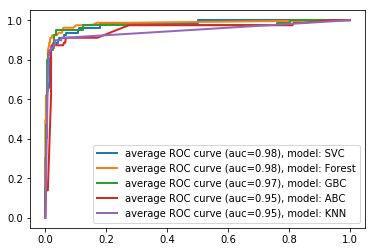

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

def train_model(X, y, est, grid):
    gs = GridSearchCV(estimator=est, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)
    gs = gs.fit(X, y)
    
    return (gs.best_estimator_, gs.best_params_)


def eval_model(mod, X_test, y_test, mod_name, plt_roc=True):
    y_prob = mod.predict_proba(X_test)
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6, 7])
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc = auc(fpr, tpr)
    
    if plt_roc:
        plt.plot(fpr, tpr, lw=2,
                 label='average ROC curve (auc=%0.2f), model: %s' % (roc_auc,mod_name))
        plt.legend(loc="lower right")
    
    y_pred = mod.predict(X_test)
    score = accuracy_score(y_true=y_test, y_pred=y_pred)
    print('Accuracy score on the test set: %.3f' %score)
    
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    confmat = pd.DataFrame(confmat, index=list(range(1,8)), columns=list(range(1,8)))
    print ('Confusion Matrix...')
    print (confmat)
    
    return (roc_auc, score)


data = read_data('1')
param_range = [0.0001, 0.001, 0.01, 0.1]

feats, y = get_features(data, wsize='10s')
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25, random_state=0, stratify=y)


print('Support Vector Machine')
model, params = train_model(X_train, y_train, 
                    est=SVC(probability=True),
                    grid={'C': param_range, 'gamma': param_range, 'kernel': ['linear']})
eval_model(model, X_test, y_test, 'SVC')
              


print ('Random Forest')
model, params = train_model(X_train, y_train, 
                    est=RandomForestClassifier(n_jobs=-1, criterion='entropy'),
                    grid={'n_estimators':[50, 100, 200]})
eval_model(model, X_test, y_test,'Forest')

print ('Gradient Boosting')
model, params = train_model(X_train, y_train, 
                    est=GradientBoostingClassifier(learning_rate=1.0, random_state=0),
                    grid={'n_estimators':[50, 200, 400], 'max_depth':[1,2,3],
                          'learning_rate':[.1,.05,.01,.005]})
eval_model(model, X_test, y_test,'GBC')

print ('Ada Boosting')
model, params = train_model(X_train, y_train, 
                    est=AdaBoostClassifier(),
                    grid={'n_estimators':[50, 200, 400], 'learning_rate':[.1,.05,.01,.005]})
eval_model(model, X_test, y_test,'ABC')

print ('K-Nearest Neighbor')
model, params = train_model(X_train, y_train, 
                    est=KNeighborsClassifier(),
                    grid={'n_neighbors':[5, 8, 10], 'weights':['uniform', 'distance']})
eval_model(model, X_test, y_test,'KNN')




In [20]:
def get_features2(data, wsize_sec, overlap=.5):
    
    wsize = 52 * wsize_sec   # sampling frequency/sec * length of window in seconds
    #feats = pd.rolling_mean(data[['x','y','z']], wsize, wsize/2).add_suffix('_mean')
    feats = data[['x','y','z']].rolling(wsize,int(wsize/2)).mean().add_suffix('_mean')
    
    #feat = pd.rolling_std(data[['x','y','z']], wsize, wsize/2).add_suffix('_std')
    feat = data[['x','y','z']].rolling(wsize, int(wsize/2)).std().add_suffix('_std')
    feats = feats.join(feat)
    
    #feat = pd.rolling_var(data[['x','y','z']], wsize, wsize/2).add_suffix('_var')
    
    feat = data[['x','y','z']].rolling(wsize, int(wsize/2)).var().add_suffix('_var')
    feats = feats.join(feat)

    #feat = pd.rolling_apply(data[['x','y','z']], wsize, rms, wsize/2).add_suffix('_rms')
    feat = data[['x','y','z']].swifter.rolling(wsize, int(wsize/2)).apply(rms).add_suffix('_rms')
    feats = feats.join(feat)
        
    #mean_mag = pd.rolling_apply((data**2).sum(axis=1), wsize, lambda ts: np.sqrt(ts).mean(), wsize/2)
    mean_mag = (data**2).sum(axis=1).rolling(wsize, int(wsize/2)).aplly(lambda ts: np.sqrt(ts).mean())
    
    mean_mag.name = 'mean_mag'
    feats = feats.join(mean_mag) 
 

    xy_cor = pd.rolling_corr(data['x'], data['y'], wsize, wsize/2)
    xy_cor.name = 'xy'
    xz_cor = pd.rolling_corr(data['x'], data['z'], wsize, wsize/2)
    xz_cor.name = 'xz'
    yz_cor = pd.rolling_corr(data['y'], data['z'], wsize, wsize/2)
    yz_cor.name = 'yz'
    feats = feats.join(xy_cor).join(xz_cor).join(yz_cor)
    
    y = pd.rolling_apply(data['label'], wsize, lambda ts: mode(ts)[0], wsize/2)   
    # Take the values at the needed intersection point
    feats = feats.iloc[wsize*overlap::wsize*overlap] 
    y = y.iloc[wsize*overlap::wsize*overlap]
    
    return feats, y


win_sizes = ['2','3', '5', '7', '10', '13', '15', '20']
best_model = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=50)

for wsize in win_sizes:
    print ('Window Size: %s sec' % wsize)
    try:
        # disjoint window
        print ('Disjoint window:')
        feats, y = get_features(data, wsize=wsize + 's')
        X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25,
                                                            random_state=0, stratify=y)
        best_model.fit(X_train, y_train)
        roc_auc, acc = eval_model(best_model, X_test, y_test,'%ss - disjoint' %wsize, plt_roc=False)
        print ('AUC score: %.3f' % roc_auc)


        # overlapping window
        print ('Overlapping window:')
        feats, y = get_features2(data, int(wsize))
        X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25,
                                                            random_state=0, stratify=y)
        best_model.fit(X_train, y_train)
        roc_auc, acc = eval_model(best_model, X_test, y_test,'%ss - overlapping' %wsize, plt_roc=False)
        print ('AUC score: %.3f' % roc_auc)
    except Exception as e:
        print (e)

    

Window Size: 2 sec
Disjoint window:
Accuracy score on the test set: 0.905
Confusion Matrix...
    1  2  3   4  5  6    7
1  78  0  0   1  0  0    2
2   0  0  0   1  0  0    1
3   0  0  9   2  0  0   16
4   0  0  0  60  1  0    3
5   0  0  0   1  6  0    1
6   0  0  0   6  0  1    0
7   1  0  1   0  0  0  200
AUC score: 0.989
Overlapping window:
'bool' object has no attribute 'lower'
Window Size: 3 sec
Disjoint window:
Accuracy score on the test set: 0.904
Confusion Matrix...
    1  2  3   4  5  6    7
1  54  0  0   0  0  0    0
2   1  0  0   0  0  0    0
3   0  0  3   1  0  0   14
4   0  0  0  40  1  2    0
5   0  0  0   0  3  0    2
6   0  0  1   3  0  1    0
7   0  0  0   0  0  0  135
AUC score: 0.990
Overlapping window:
'bool' object has no attribute 'lower'
Window Size: 5 sec
Disjoint window:


KeyboardInterrupt: 

In [17]:
data2 = read_data('all') 
feats, y = get_features2(data2, 2)
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25,
                                                    random_state=0, stratify=y)
best_model.fit(X_train, y_train)
eval_model(best_model, X_test, y_test,'2sec - overlapping')


AttributeError: 'bool' object has no attribute 'lower'